# VAE model training and selection

This notebook shows how the parameter space for B-VAEs (Beta-Variational Autoencoders) can be explored for different values of the Beta and capacitance parameters. The theory is described at length in the author's [PhD](https://discovery.ucl.ac.uk/id/eprint/10134012/) and the accompanying preprint [Untangling urban data signatures](https://arxiv.org/abs/2106.15363).

This work is distinguished by:

- Use of numerical as opposed to image-based analysis. In this sense, VAE are used to sift-out themes from large urban datasets and do so as a function of input variables such as network centralities, landuse accessibilities, etc. This means that the ensuing themes discovered from the data can be related to the input metrics in a way that is theoretically meaningful for day-to-day urban data exploration and urban planning.
- Use and development of methods to "untangle" the latent factors within these datasets so that latent dimensions more cleanly represent underlying themes within the data.

See the accompanying [vae_exploration]() notebook showing some of the ways in which the selected VAE model can be used.


## Notebook Setup


In [1]:
import os
from pathlib import Path

print(f"Launch directory: {os.getcwd()}")

if os.getcwd().endswith("/demos/vae"):
    os.chdir("..")
elif not os.getcwd().endswith("/demos"):
    print("Please run this notebook from the demos directory")
print(f"Working directory: {os.getcwd()}")

Launch directory: /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/vae
Working directory: /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos


## Data preprocessing

A sample of the data is here provided for reproducibility of the methods. The sample dataset covers inner and north London and derives from a larger dataset which spans England and Wales.

Original versions of this work were applied to proprietary data (per the above PhD); however, this version of the dataset is purely based on open sources of data:

- The road network is derived from [OpenStreetMap](https://www.openstreetmap.org) (Open Database License). This is selected in this instance over OS Open Roads, which lacks pedestrian paths. The downloading, network cleaning, network decomposition, and calculation of network centralities is done with the `cityseer` package.
- Information on eating and drinking establishments is derived from the [Food Standards Agency API](https://ratings.food.gov.uk/open-data/en-GB) (Open Government License) dataset. The `cityseer` package is used to assign locations to the closest adjacent roadway and for computing landuse accessibilities to eateries, retail, drinking establishments, take-aways, and for calculating a mixed-use measure from the above.
- A "human capital" measure is developed from [Companies House](https://data.gov.uk/dataset/4462e41a-7413-4359-97f5-420b6ca5f9c0/basic-company-data) data (Creative Commons Attribution License). `cityseer` is used to assigned the locations to the closest adjacent roadway and for calculating a Hill Diversity measure. Due to ambiguity over business registration locations this data is treated as a proxy of human capital rather than for detailed landuse analysis.
- [Naptan Data](https://data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan) (Open Government License) is used for Bus Stop and Railway Station locations and associated accessibilities.
- Census data is from [UK Data Service](https://borders.ukdataservice.ac.uk) (Open Government License). The granularity of this data is not sufficient for direct assignment to nearby roadways, a combination of interpolative and distance weighted aggregation methods has therefore been used instead.

The first step of analysis unpacks the data from the dataset and applies a standard-scaler transformation so that the data is mean-centred and scaled to unit variance.


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

from general_util import theme_setup

# load data
print((theme_setup.data_path / "df_north_london.feather").resolve())
df = pd.read_feather((theme_setup.data_path / "df_north_london.feather").resolve())
df = df.set_index("uid")
print(df.head())

# test indices
test_idxs = theme_setup.train_test_idxs(df, mod=200)

# preprocess data
X_raw, distances, labels = theme_setup.generate_theme(df, "all", bandwise=True, max_dist=None)
X_trans = StandardScaler().fit_transform(X_raw)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/data/df_north_london.feather
                             index  city_id              x              y  \
uid                                                                         
1-10934|90859±0±33463|10493      0        1  530342.873862  182325.087819   
1-330945707±5±357415633          1        1  527035.735672  187544.429602   
1-1459408967                     2        1  532164.776922  188193.929012   
1-26004973±6295862385            3        1  532001.390841  193891.914603   
1-7707806504                     4        1  535259.874968  180594.001376   

                             c_segment_density_100  c_segment_density_200  \
uid                                                                         
1-10934|90859±0±33463|10493             680.833374            2017.945068   
1-330945707±5±357415633                 216.558105             731.756958   
1-1459408967                            257.169739             809.

## VAE model runs

The VAE model is run for 10 different random starting seeds for a range of beta and capacitance parameters. This translates into 481 models, which will be trained, with the weights then saved for subsequent processing.


In [3]:
from IPython.utils import io
from vae.vae_util import vae_model, vae_runner

# setup params
epochs = 25
batch = 256
latent_dim = 6
lr = 1e-3
for seed in range(10):
    for beta in (0, 1, 2, 4, 8, 16, 32, 64):
        for cap in (0, 4, 8, 12, 16, 20):
            if beta == 0 and cap > 0:
                continue
            # generate identifying model key
            model_key = f"VAE_d{latent_dim}_b{beta}_c{cap}_s{seed}"
            dir_path = Path(theme_setup.weights_path / f"vae/seed_{seed}/{model_key}_e{epochs}_b{batch}_train")
            # skip if weights are already saved
            if dir_path.exists():
                print(f"Found existing weights, skipping {model_key}.")
                continue
            print(f"Processing {model_key}.")
            # creates model
            vae = vae_model.VAE(
                raw_dim=X_trans.shape[1],
                latent_dim=latent_dim,
                beta=beta,
                capacity=cap,
                epochs=epochs,
                model_key=model_key,
                seed=seed,
            )
            # trains model
            trainer = vae_runner.VAE_trainer(
                model=vae,
                X_samples=X_trans,
                labels=labels,
                distances=distances,
                epochs=epochs,
                batch=batch,
                best_loss=False,  # KL divergence increases with capacity
                lr=lr,
                save_path=dir_path,
                test_indices=test_idxs,
            )
            # reduce cell content output from training multiple models
            with io.capture_output() as captured:
                trainer.train()

Found existing weights, skipping VAE_d6_b0_c0_s0.
Found existing weights, skipping VAE_d6_b1_c0_s0.
Found existing weights, skipping VAE_d6_b1_c4_s0.
Found existing weights, skipping VAE_d6_b1_c8_s0.
Found existing weights, skipping VAE_d6_b1_c12_s0.
Found existing weights, skipping VAE_d6_b1_c16_s0.
Found existing weights, skipping VAE_d6_b1_c20_s0.
Found existing weights, skipping VAE_d6_b2_c0_s0.
Found existing weights, skipping VAE_d6_b2_c4_s0.
Found existing weights, skipping VAE_d6_b2_c8_s0.
Found existing weights, skipping VAE_d6_b2_c12_s0.
Found existing weights, skipping VAE_d6_b2_c16_s0.
Found existing weights, skipping VAE_d6_b2_c20_s0.
Found existing weights, skipping VAE_d6_b4_c0_s0.
Found existing weights, skipping VAE_d6_b4_c4_s0.
Found existing weights, skipping VAE_d6_b4_c8_s0.
Found existing weights, skipping VAE_d6_b4_c12_s0.
Found existing weights, skipping VAE_d6_b4_c16_s0.
Found existing weights, skipping VAE_d6_b4_c20_s0.
Found existing weights, skipping VAE_d6_b

## Latents preprocessing

Once the models weights have been generated, the latents can be extracted and packaged into intermediate data structures for subsequent plots.


In [4]:
from vae.vae_util import methods

methods.process_latents_vae()

Generating bandwise data
...collecting seeds from models for beta 0 and capacitance 0
...collecting seeds from models for beta 1 and capacitance 0
...collecting seeds from models for beta 1 and capacitance 4
...collecting seeds from models for beta 1 and capacitance 8
...collecting seeds from models for beta 1 and capacitance 12
...collecting seeds from models for beta 1 and capacitance 16
...collecting seeds from models for beta 1 and capacitance 20
...collecting seeds from models for beta 2 and capacitance 0
...collecting seeds from models for beta 2 and capacitance 4
...collecting seeds from models for beta 2 and capacitance 8
...collecting seeds from models for beta 2 and capacitance 12
...collecting seeds from models for beta 2 and capacitance 16
...collecting seeds from models for beta 2 and capacitance 20
...collecting seeds from models for beta 4 and capacitance 0
...collecting seeds from models for beta 4 and capacitance 4
...collecting seeds from models for beta 4 and capacit

A grid-plot of model


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

epochs = 25
seeds = list(range(10))
latent_dims = [6]
history_data = methods.gather_loss(seeds, epochs, latent_dims)
# returns 3d array - beta x caps x seeds
# load files if already calculated, otherwise compute, then save
udr_path = Path(theme_setup.weights_path / f"vae/data/udr_scores.npy")
udr_mask_path = Path(theme_setup.weights_path / f"vae/data/udr_mask_counts.npy")
if not udr_path.exists():
    print("UDR data does not exist, creating...")
    udr_arr, udr_mask_count_arr = methods.generate_udr_grid(latent_dims[0], epochs, seeds, kl_threshold=0.01)
    np.save(str(udr_path), udr_arr)
    np.save(str(udr_mask_path), udr_mask_count_arr)
else:
    print("Loading precomputed UDR data")
    udr_arr = np.load(str(udr_path))
    udr_mask_count_arr = np.load(str(udr_mask_path))

Loading precomputed UDR data:


NameError: name 'util_funcs' is not defined

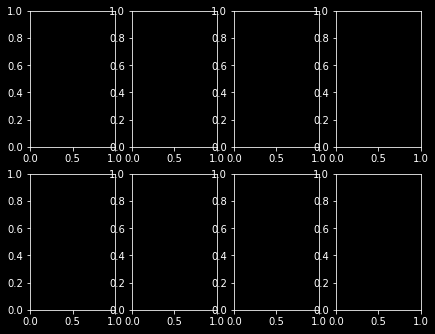

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(7, 5.5))
theme_sets = [
    ["val_loss", "val_rec_loss", "udr", "mask"],
    ["val_capacity_term", "val_kl", "val_kl_beta", "val_kl_beta_cap"],
]
for ax_row_n, (ax_row, theme_row) in enumerate(zip(axes, theme_sets)):
    for ax_col_n, (ax, theme) in enumerate(zip(ax_row, theme_row)):
        if theme == "udr":
            green_cmap = plt.get_cmap("Greens")
            # take mean across seeds on dimension 2
            udr_arr_mu = np.nanmean(udr_arr, axis=2)
            methods.generate_arr_heatmap(ax, udr_arr_mu, cmap=green_cmap, constrain=(0, 1))
            ax.set_xlabel("UDR score")
        elif theme == "mask":
            green_cmap = plt.get_cmap("Greens")
            # take mean across seeds on dimension 2
            udr_mask_count_arr_mu = np.nanmean(udr_mask_count_arr, axis=2)
            methods.generate_arr_heatmap(ax, udr_mask_count_arr_mu, cmap=green_cmap, constrain=(0, 1))
            ax.set_xlabel("Active axes")
        else:
            methods.generate_heatmap(
                ax,
                theme,
                epochs,
                latent_dims[0],
                history_data,
                set_row_labels=ax_col_n == 0,
                set_col_labels=ax_row_n == 0,
            )
plt.suptitle(r"10 seed avg. losses for $\beta$ and $C$ hyperparameters (" + f"{epochs} epochs)")
# path = f'model_scores_fine.pdf'
plt.show()